In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [169]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from scipy.stats import boxcox
from tqdm.notebook import tqdm


In [3]:
plt.rcParams['figure.figsize'] = (15, 8)

In [4]:
base_db = pd.read_csv("../output/base_db.csv").drop(columns="Unnamed: 0")

## Matrix factorization

In [170]:
# function to compute RMSE (needs correct matrices)
def compute_rmse(X_real, X_predict):
    # total rmse on seen data
    dim = X_real.index.size
    s = 0
    for _, row in tqdm(X_real.iterrows()):
        s+=0.5*(row.score - X_predict[int(row.test_cas), int(row.species)])**2
    rmse = np.sqrt(s/dim)
    return rmse

We want to give a score to the tuple (chemicals, specie) and compute the pericolosity of the chemicals on new species based on the score (Netflix prize problem)

In [212]:
X_fact = base_db.copy()
X_fact = X_fact[["test_cas", "species", "conc1_mean", "obs_duration_mean"]]

In [213]:
X_fact["score"] = 1/(X_fact.conc1_mean*X_fact.obs_duration_mean)

In [214]:
X_fact = X_fact.groupby(by=["test_cas", "species"]).agg("median")

In [215]:
X_fact = X_fact.drop(columns=["conc1_mean", "obs_duration_mean"]).reset_index()

In [216]:
enc = OrdinalEncoder(dtype=int)
enc.fit(X_fact[["test_cas", "species"]])
X_fact[["test_cas", "species"]] = enc.transform(X_fact[["test_cas", "species"]])

Standardize the score: apply log(x) and scale over (1,5)

In [217]:
X_fact_scored = X_fact.copy()
X_fact_scored.score = X_fact_scored.score.apply(lambda x: np.log(x))

In [218]:
# MinMax scale score
minmax = MinMaxScaler((1, 10))
minmax.fit(X_fact_scored[["score"]])
X_fact_scored[["score"]] = minmax.transform(X_fact_scored[["score"]])

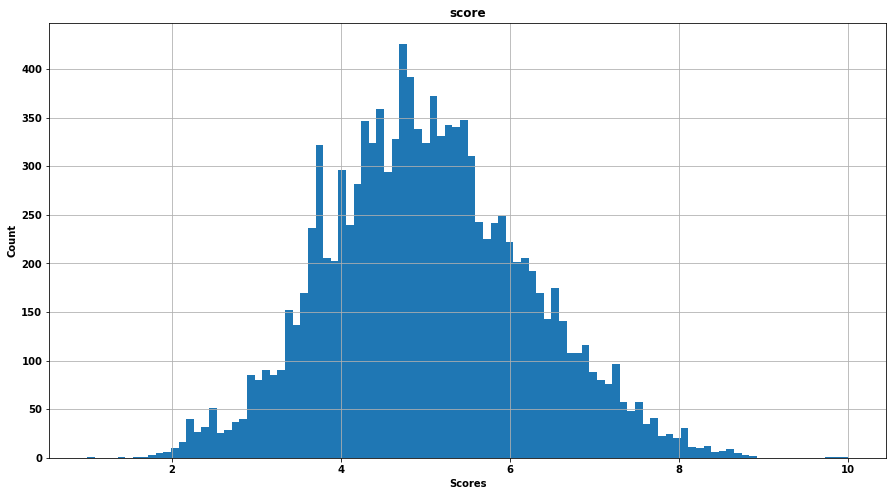

In [219]:
X_fact_scored[["score"]].hist(bins=100);
#plt.yscale("log")
#plt.xscale("log")
plt.xlabel("Scores")
plt.ylabel("Count");

Dropping the outliers:

In [220]:
# X_fact[X_fact.score > 4]

In [221]:
# X_fact = X_fact.drop(index=[5139, 5869, 8459])

In [222]:
# X_fact.score.hist()
# # plt.yscale('log')
# plt.xlabel("Scores")
# plt.ylabel("Count");

Output matrix to use with Surprise library:

In [223]:
X_fact_scored.to_csv("../output/score_matrix_nomix.csv", header=True, index=False)

In [224]:
print(X_fact_scored.test_cas.max(), X_fact_scored.species.max())

3178 493


In [227]:
X_res = pd.read_csv("../output/fact1_result.csv").drop(columns="Unnamed: 0").values

In [228]:
compute_rmse(X_fact_scored, X_res)

0.3709303915834111

In [229]:
# coming back from minmax and coxbox and measure new rmse
X_res2 = minmax.inverse_transform(X_res)
X_res2 = np.exp(X_res2)
#X_res2 = np.exp(np.log(lambda_ * X_res2 + 1) / lambda_)

In [230]:
compute_rmse(X_fact, X_res2)

173.50515078784983

In [231]:
X_fact

,test_cas,species,score
0,0,5,0.000132
1,0,9,0.008869
2,0,39,0.001190
3,0,89,0.000267
4,0,103,0.000069
...,...,...,...
11645,3174,393,0.001566
11646,3175,393,0.000769
11647,3176,394,0.974727
11648,3177,394,0.487900


In [232]:
X_res3 = 1/(X_res2)

In [233]:
X_fact_inv = X_fact.copy()
X_fact_inv.score = 1/(X_fact_inv.score)

In [234]:
compute_rmse(X_fact_inv, X_res3)

326985.7899714786

In [235]:
X_fact_inv

,test_cas,species,score
0,0,5,7590.280374
1,0,9,112.748936
2,0,39,840.000000
3,0,89,3744.000000
4,0,103,14518.165728
...,...,...,...
11645,3174,393,638.400000
11646,3175,393,1300.800000
11647,3176,394,1.025928
11648,3177,394,2.049600


Preparing matrix for lab code:

In [46]:
# X_fact["id"] = "r" + X_fact.test_cas.astype("str") + '_' + "c"+ X_fact.species.astype("str")

In [47]:
# X_fact = X_fact[["id", "score"]].set_index("id")
# X_fact.to_csv("../output/score_matrix.csv", header=True)

#### Another tentative of scoring

In [251]:
X_fact = base_db.copy()
X_fact = X_fact[["test_cas", "species", "conc1_mean", "obs_duration_mean"]]
X_fact["score"] = 1/(X_fact.conc1_mean*X_fact.obs_duration_mean)
X_fact = X_fact.groupby(by=["test_cas", "species"]).agg("median")
X_fact = X_fact.drop(columns=["conc1_mean", "obs_duration_mean"]).reset_index()
enc = OrdinalEncoder(dtype=int)
enc.fit(X_fact[["test_cas", "species"]])
X_fact[["test_cas", "species"]] = enc.transform(X_fact[["test_cas", "species"]])

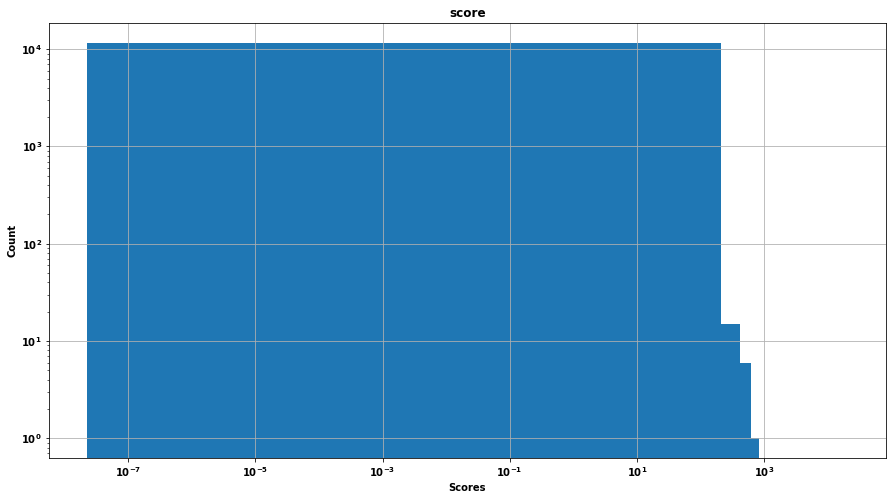

In [252]:
X_fact[["score"]].hist(bins=100);
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Scores")
plt.ylabel("Count");

Giving a score based on the distribution:
- $ < (10^-5)$ -> score 1
- $ >(10^-5)$ and $ <(10^-3)$ -> score 2
- $ >(10^-3)$ and $ <(10^-1)$ -> score 3
- $ >(10^-1)$ and $ <(10^11)$ -> score 4
- $ >(10^1)$ -> score 5

In [253]:
def scores_cat(x):
    if (x <= 10**-5):
        return 1
    elif ((x>10**-5) and (x<=10**-3)):
        return 2
    elif ((x>10**-3) and (x<=10**-1)):
        return 3
    elif ((x>10**-1) and (x<=10**1)):
        return 4
    else:
        return 5

In [254]:
X_fact_scored = X_fact.copy()
X_fact_scored.score = X_fact_scored.score.apply(lambda x: scores_cat(x))

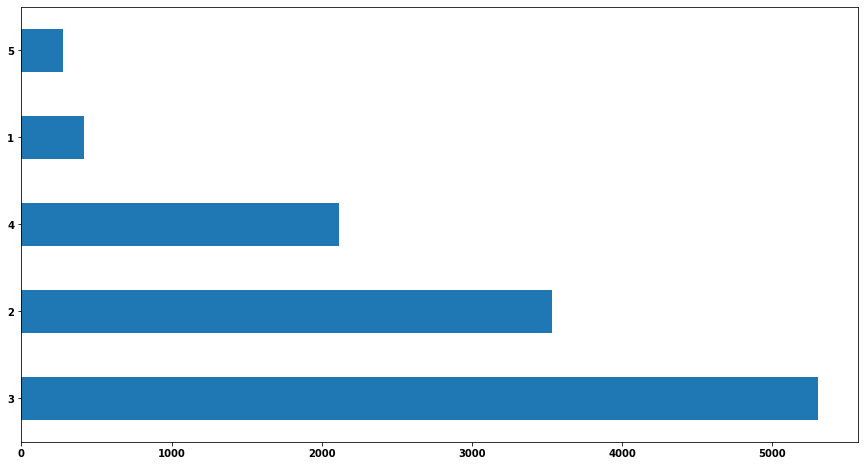

In [255]:
X_fact_scored.score.value_counts().plot(kind="barh");

In [256]:
X_fact_scored.score.value_counts()

3    5306
2    3530
4    2115
1     420
5     279
Name: score, dtype: int64

In [257]:
X_fact_scored.to_csv("../output/score_matrix_cat.csv", header=True, index=False)

In [258]:
X_res = pd.read_csv("../output/fact2_result.csv").drop(columns="Unnamed: 0").values

In [259]:
compute_rmse(X_fact_scored, X_res)

0.37923573472085986

# NEW SCORE TENTATIVES

## CONSIDERING ONLY 96 H

In [260]:
X_fact = base_db.copy()
X_fact = X_fact[["test_cas", "species", "conc1_mean", "obs_duration_mean"]]

In [261]:
X_fact = X_fact[X_fact.obs_duration_mean==96]

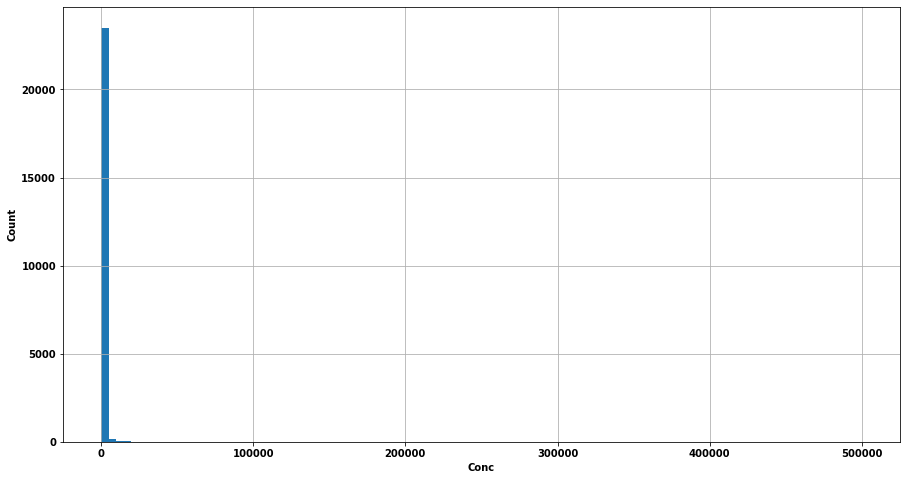

In [262]:
# plotting the distribution of conc inside this case
X_fact.conc1_mean.hist(bins=100)
#plt.yscale('log')
plt.xlabel("Conc")
plt.ylabel("Count");

In [263]:
# # applying coxbox transformation to reduce skewness
# X_fact.conc1_mean, lambda_ = boxcox(X_fact.conc1_mean)
# X_fact.conc1_mean.hist(bins=100)
# #plt.yscale('log')
# plt.xlabel("Conc")
# plt.ylabel("Count");

In [264]:
# function to come back from coxbox
#te = np.exp(np.log(lambda_ * X_fact.conc1_mean + 1) / lambda_)

In [265]:
X_fact["score"] = 1/X_fact.conc1_mean

In [266]:
X_fact = X_fact.groupby(by=["test_cas", "species"]).agg("median")
X_fact = X_fact.drop(columns=["conc1_mean", "obs_duration_mean"]).reset_index()

In [267]:
enc = OrdinalEncoder(dtype=int)
enc.fit(X_fact[["test_cas", "species"]])
X_fact[["test_cas", "species"]] = enc.transform(X_fact[["test_cas", "species"]])

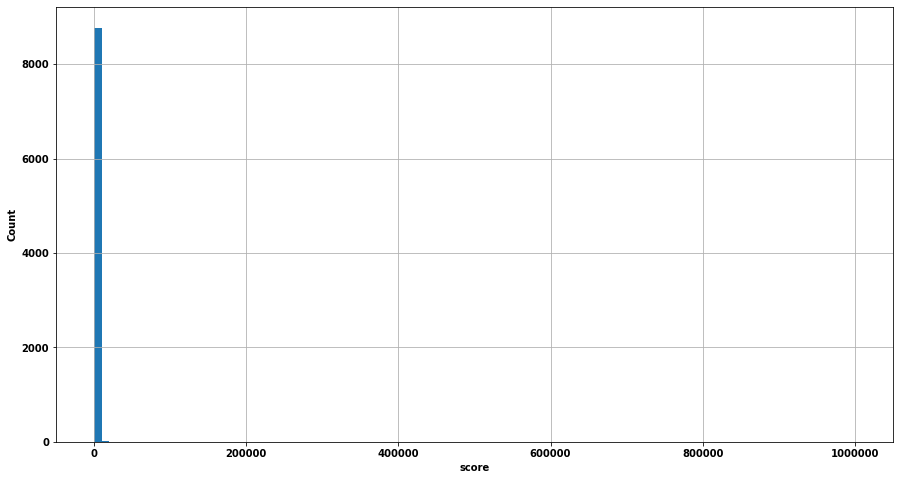

In [268]:
# plotting the distribution of conc inside this case
X_fact.score.hist(bins=100)
#plt.yscale('log')
plt.xlabel("score")
plt.ylabel("Count");

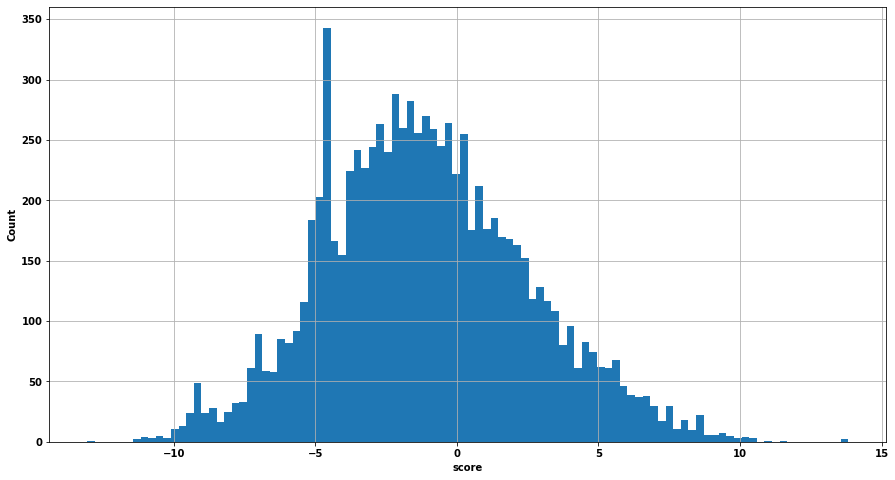

In [269]:
X_fact_proc = X_fact.copy()
X_fact_proc.score = X_fact_proc.score.apply(lambda x: np.log(x))
# plotting the distribution of conc inside this case
X_fact_proc.score.hist(bins=100)
#plt.yscale('log')
plt.xlabel("score")
plt.ylabel("Count");

In [270]:
# # applying coxbox transformation to reduce skewness
# X_fact.score = boxcox(X_fact.score, lmbda=-1)
# X_fact.score.hist(bins=100)
# #plt.yscale('log')
# plt.xlabel("Conc")
# plt.ylabel("Count");

In [271]:
# MinMax scale score
minmax = MinMaxScaler((1, 20))
minmax.fit(X_fact_proc[["score"]])
X_fact_proc[["score"]] = minmax.transform(X_fact_proc[["score"]])

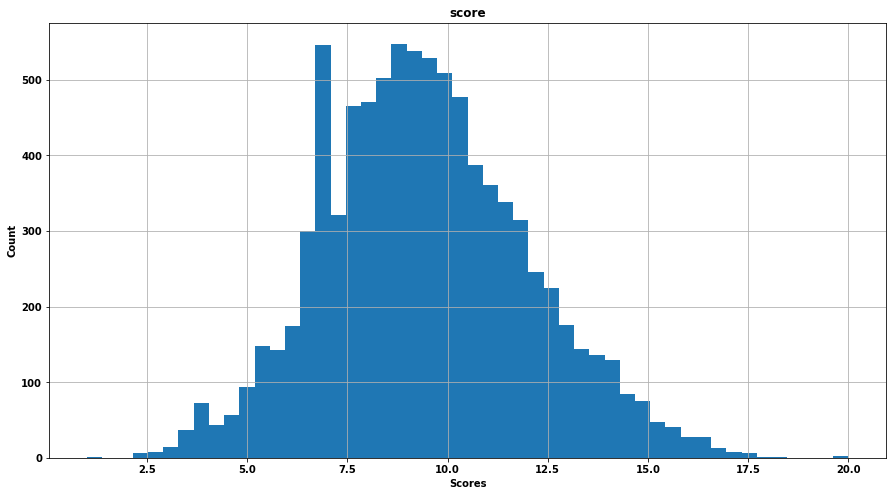

In [272]:
X_fact_proc[["score"]].hist(bins=50);
#plt.yscale("log")
#plt.xscale("log")
plt.xlabel("Scores")
plt.ylabel("Count");

Output matrix to use with Surprise library:

In [273]:
X_fact_proc.to_csv("../output/score_matrix_96h.csv", header=True, index=False)

In [274]:
X_fact

,test_cas,species,score
0,0,3,0.007616
1,0,71,0.013966
2,0,82,0.004310
3,0,131,0.008696
4,0,167,0.009615
...,...,...,...
8795,2577,330,1623.376623
8796,2578,330,892.857143
8797,2579,330,609.384522
8798,2580,331,46.838407


In [275]:
X_fact_proc

,test_cas,species,score
0,0,3,6.779717
1,0,71,7.208575
2,0,82,6.377123
3,0,131,6.873462
4,0,167,6.944568
...,...,...,...
8795,2577,330,15.457275
8796,2578,330,15.034465
8797,2579,330,14.764319
8798,2580,331,12.949741


In [289]:
X_res = pd.read_csv("../output/fact3_result.csv").drop(columns="Unnamed: 0").values

In [291]:
compute_rmse(X_fact_proc, X_res)

0.22749346387557953

In [292]:
# coming back from minmax and coxbox and measure new rmse
X_res2 = minmax.inverse_transform(X_res)
X_res2 = np.exp(X_res2)
#X_res2 = np.exp(np.log(lambda_ * X_res2 + 1) / lambda_)

In [293]:
compute_rmse(X_fact, X_res2)

506.78904829028284

In [296]:
X_fact

,test_cas,species,score
0,0,3,0.007616
1,0,71,0.013966
2,0,82,0.004310
3,0,131,0.008696
4,0,167,0.009615
...,...,...,...
8795,2577,330,1623.376623
8796,2578,330,892.857143
8797,2579,330,609.384522
8798,2580,331,46.838407


In [299]:
X_res2[0, 3]

0.009269047009291839

In [301]:
X_res3 = 1/X_res2
X_conc = X_fact.copy()
X_conc.score = 1/(X_conc.score)

In [302]:
compute_rmse(X_conc, X_res3)

1017.3894070439042

In [304]:
X_conc

,test_cas,species,score
0,0,3,131.300000
1,0,71,71.600000
2,0,82,232.000000
3,0,131,115.000000
4,0,167,104.000000
...,...,...,...
8795,2577,330,0.000616
8796,2578,330,0.001120
8797,2579,330,0.001641
8798,2580,331,0.021350


In [309]:
X_res3[0, 167]

88.77170606631856